_This is a continuation from the first notebook, found [here](../code/Amazon-product-catalog-cleaning-EDA.ipynb)_


# Amazon product ratings predictor

## Imports

In [2]:
#import libraries
#basic ops
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, re

#other helper functions
from pandasql import sqldf
from math import pi

#show grid on plots
sns.set_style('darkgrid')

#display tables without ellipsis
#pd.set_option('display.max_rows', None)


#NLP
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import RegexpTokenizer

#import gensim.downloader as api #allows us to get word2vec anf glove embeddings that we need
#from gensim.models.word2vec import Word2Vec
#from transformers import pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#modeling
from sklearn.linear_model import LinearRegression, LogisticRegression, \
                                 Ridge, RidgeCV, Lasso, LassoCV

#+ pull in random forest!
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.dummy import DummyRegressor

In [6]:
#read in data
ecom = pd.read_csv('../data/ecom.csv')

In [49]:
ecom.columns

Index(['index', 'uniq_id', 'product_name', 'price',
       'number_available_in_stock', 'number_of_reviews',
       'number_of_answered_questions', 'average_review_rating',
       'customers_who_bought_this_item_also_bought', 'description',
       ...
       'amazon_category_and_sub_category_Sports Toys & Outdoor > Racket Games',
       'amazon_category_and_sub_category_Sports Toys & Outdoor > Target Games',
       'amazon_category_and_sub_category_Storage, Cleaning & Ring Sizers > Boxes & Organisers',
       'amazon_category_and_sub_category_Supporters' Gear > Football > Memorabilia & Collectibles',
       'amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate',
       'amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars',
       'amazon_category_and_sub_category_Women > Accessories',
       'amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses',
       'amazon_category_and_sub_category_Women 

In [7]:
ecom.head()

,uniq_id,product_name,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,customers_who_bought_this_item_also_bought,description,product_information,...,amazon_category_and_sub_category_Sports Toys & Outdoor > Racket Games,amazon_category_and_sub_category_Sports Toys & Outdoor > Target Games,"amazon_category_and_sub_category_Storage, Cleaning & Ring Sizers > Boxes & Organisers",amazon_category_and_sub_category_Supporters' Gear > Football > Memorabilia & Collectibles,"amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate","amazon_category_and_sub_category_Sweets, Chocolate & Gum > Chocolate > Bars > Multipack Bars",amazon_category_and_sub_category_Women > Accessories,amazon_category_and_sub_category_Women > Accessories > Eyewear & Accessories > Sunglasses,amazon_category_and_sub_category_Women > Tops & T-Shirts,amazon_category_and_sub_category_Worlds Apart > Kid Venture > Kites
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,3.42,5 new,15,1.0,4.9,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,16.99,0,2,1.0,4.0,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,...,0,0,0,0,0,0,0,0,0,0
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,9.99,2 new,17,2.0,3.9,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,...,0,0,0,0,0,0,0,0,0,0
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,39.99,0,1,2.0,0.0,0,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,32.19,0,3,2.0,4.7,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#check for nulls now that data has been through and export / import process
ecom.isna().sum().sort_values(ascending=False)

amazon_category_and_sub_category_Worlds Apart > Kid Venture > Kites    0
manufacturer_Hansa                                                     0
manufacturer_Hanayama                                                  0
manufacturer_Hamleys                                                   0
manufacturer_Hama Beads DKL                                            0
                                                                      ..
manufacturer_Scream                                                    0
manufacturer_Scratch                                                   0
manufacturer_Scrabble                                                  0
manufacturer_Scoot                                                     0
uniq_id                                                                0
Length: 2917, dtype: int64

In [10]:
ecom['customer_reviews'] = ecom['customer_reviews'].fillna('')

## NLP

Open questions:

* Sentiment of reviews
* Does sentiment correspond to star rating?
* Most interesting question bi-grams
* Most interesting review bi-grams

### Word frequencies

In [43]:
#vectorize text. NOTE: Run the RegEx to remove line breaks from customer review and
#questions columns, first!

#ensure that our inputs are actual strings
ecom['customer_reviews'] = ecom['customer_reviews'].astype('string')
ecom['customer_questions_and_answers'] = ecom['customer_questions_and_answers'].astype(
'string')

#instantiate count vec used for word freq analysis
cvec = CountVectorizer(stop_words='english', max_features=2000) 

#define our columns to use in vectorizer functions
reviews = ecom['customer_reviews'] 
questions = ecom['customer_questions_and_answers']

#function to vectorize
def vectorize(column): #plug in whatever we need to vectorize from df here

    transformed_df = cvec.fit_transform(column)

    transformed_df = pd.DataFrame(
        transformed_df.todense(), columns = cvec.get_feature_names())
    
    #get most important words
    #print('Top 30 most common words in Amazon ' + column)
    
    freq = pd.DataFrame(transformed_df.sum().sort_values(
        ascending=False)[:30], columns=['Frequency'])
    
    return freq

In [44]:
vectorize(reviews)

,Frequency
2015,21272
2014,14045
great,11469
good,11057
2013,9329
jan,9225
dec,7797
stars,7273
2016,5876
nov,5404


In [45]:
vectorize(questions)

,Frequency
does,391
yes,333
hi,293
size,239
just,216
cards,195
box,173
set,158
thanks,156
know,153


Among these, words like 'game', 'old' and 'quality' might be of some interest. However, it's a bit tricky to derive very much meaning from standalone words, so we should look at word groups.

### Bigrams and trigrams

#### Bigrams

In [46]:
#reviews
cvec_2 = CountVectorizer(ngram_range=(2,2),stop_words="english") 
bigrams = cvec_2.fit_transform(reviews)
bigrams = pd.DataFrame(
    bigrams.todense(), columns=cvec_2.get_feature_names())
bigrams.sum().sort_values(ascending=False).head(10)

jan 2016        3308
dec 2015        3184
year old        2728
jan 2015        2342
nov 2015        2219
dec 2014        1966
oct 2015        1853
good quality    1788
feb 2015        1600
mar 2015        1526
dtype: int64

In [50]:
#cust q's
cvec_2 = CountVectorizer(ngram_range=(2,2),stop_words="english") 
bigrams = cvec_2.fit_transform(questions)
bigrams = pd.DataFrame(
    bigrams.todense(), columns=cvec_2.get_feature_names())
bigrams.sum().sort_values(ascending=False).head(10)

hope helps      115
year old         97
does come        61
don know         34
hi yes           27
yes does         25
kind regards     23
thanks hi        21
sorry don        18
does know        17
dtype: int64

#### Trigrams

In [51]:
#reviews
cvec_3 = CountVectorizer(ngram_range=(3,3),stop_words="english") 
trigrams = cvec_3.fit_transform(reviews)
trigrams = pd.DataFrame(trigrams.todense(), columns=cvec_3.get_feature_names())
trigrams.sum().sort_values(ascending=False).head(10)

2015 amazon customer        642
2016 amazon customer        423
good value money            408
year old son                371
bought year old             264
dec 2015 amazon             250
jan 2016 amazon             240
people following review     239
following review helpful    239
year old daughter           234
dtype: int64

About the only interesting bits here are 'year old son', 'bought year old' and 'year old daughter', which tie in well with the kinds of things we saw people shopping for in our dataset.

In [52]:
#cust q's
cvec_3 = CountVectorizer(ngram_range=(3,3),stop_words="english") 
trigrams = cvec_3.fit_transform(questions)
trigrams = pd.DataFrame(trigrams.todense(), columns=cvec_3.get_feature_names())
trigrams.sum().sort_values(ascending=False).head(10)

sorry don know           15
suitable year old        11
hope helps does           8
does item come            7
www amazon uk             6
official rainbow loom     5
old year old              5
amazon uk gp              5
year old son              5
mega metagross ex         5
dtype: int64

"Suitable year old" is actually revealing about a top concern -- so this is helpful.

### Customer review sentiment analysis

In [15]:
#First, convert to a list of strings; full reference in this entire section to the sentiment analysis lesson from Heather Robbins
corpus = list(ecom['customer_reviews'])
while("" in corpus) : corpus.remove("") #from: https://www.geeksforgeeks.org/python-remove-empty-strings-from-list-of-strings/
print(len(corpus))
corpus[:10]

9979


["Worth Buying For The Pictures Alone (As Ever)  4.0  6 April 2014  By        Copnovelist   on 6 April 2014  Part of the magic for me growing up as a boy was to buy (or be given) the new Hornby catalogue every year, even if it included 90% of the same products as the previous year.  I've still got my old ones dating back to the 70s and 80s somewhere.  These days the catalogue is especially informative in that it tells you the vintage of the rolling stock which is useful if you are dedicating your railway to one particular era and train company.  Amazing detail fabulous photography.  5.0  11 April 2015  By        richard   on 11 April 2015  Amazing detail, every credit to the photographer in this book, a worthy reference manual, as well as a sales brochure. even if you only have a passing interest in the hobby you will be transported to another time when we were all younger and in awe of the big trains.  'Great Purchase'  5.0  23 April 2014  By        Pinkhandbag   on 23 April 2014  Thi

In [53]:
#sentiment analysis
#instantiate VADER
vader = SentimentIntensityAnalyzer()

#loop through reviews
sentiment = []    

for review in corpus:
    scores = vader.polarity_scores(review)
    scores['customer_review'] = review
    sentiment.append(scores)

sentiment_df = pd.DataFrame(sentiment)

#reset indices to match
ecom.reset_index(inplace=True)
sentiment_df.reset_index(inplace=True)

In [65]:
#set target and plot sentiment
sentiment_df['target'] =ecom['average_review_rating']

#Plot the average positivity, negativity and compound scores for target
#plt.figure(figsize=(20,12));
sentiments=sentiment_df.groupby(
    'target').mean()[['pos', 'neg', 'compound', 'neu']]

sentiments

,pos,neg,compound,neu
target,,,,
0.0,0.233589,0.019758,0.797526,0.746651
2.3,0.142000,0.083000,0.873500,0.774000
3.0,0.124400,0.026200,0.720760,0.849400
3.3,0.183500,0.031500,0.965550,0.785500
3.6,0.257000,0.037667,0.825567,0.704667
3.7,0.121000,0.036000,0.499500,0.843000
3.8,0.199000,0.028000,0.990500,0.772000
3.9,0.187000,0.058714,0.959229,0.754429
4.0,0.223656,0.023537,0.816941,0.752791


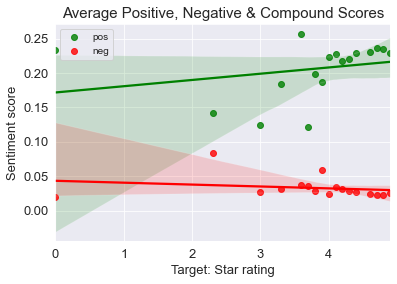

In [69]:
#sentiments.plot(kind='line');

sns.regplot(data=sentiments, x=sentiments.index, y = 'pos', color = 'green', label = 'pos')
sns.regplot(data=sentiments, x=sentiments.index, y = 'neg', color = 'red', label = 'neg')


plt.title('Average Positive, Negative & Compound Scores', size = 15);
plt.xticks(size=13);
plt.yticks(size=13);
plt.ylabel('Sentiment score', size=13);
plt.xlabel('Target: Star rating', size=13);
plt.savefig('../assets/sentiment.jpg');
plt.legend();

We can actually see a linear relationship here!

## Modeling - linear regression

In [ ]:
#strategy -- lasso, ridge (but may lose some interpretability)

In [ ]:
#reviews
#price
#category

### Evaluation

## Conclusion and next steps